In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
holidays = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
stores = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
train = pd.read_csv('store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('store-sales-time-series-forecasting/transactions.csv')
#test = pd.read_csv('store-sales-time-series-forecasting/test.csv')
#sample_submission = pd.read_csv('store-sales-time-series-forecasting/sample_submission.csv')

We're just going to go through this list and see what we're working with

In [3]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [4]:
holidays.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [5]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [6]:
holidays.description.unique()

array(['Fundacion de Manta', 'Provincializacion de Cotopaxi',
       'Fundacion de Cuenca', 'Cantonizacion de Libertad',
       'Cantonizacion de Riobamba', 'Cantonizacion del Puyo',
       'Cantonizacion de Guaranda', 'Provincializacion de Imbabura',
       'Cantonizacion de Latacunga', 'Fundacion de Machala',
       'Fundacion de Santo Domingo', 'Cantonizacion de El Carmen',
       'Cantonizacion de Cayambe', 'Fundacion de Esmeraldas',
       'Primer Grito de Independencia', 'Fundacion de Riobamba',
       'Fundacion de Ambato', 'Fundacion de Ibarra',
       'Cantonizacion de Quevedo', 'Independencia de Guayaquil',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia de Guaranda',
       'Independencia de Latacunga', 'Independencia de Ambato',
       'Fundacion de Quito-1', 'Fundacion de Quito', 'Fundacion de Loja',
       'Navidad-4', 'Cantonizac

looks like we have some football games in here that'll have to be grouped together 
"Terremoto Manabi" we'll have to take out and watch the tail effects of (it's the only unpredictible event)

So We've got a bunch of holidays and we're probably going to have to match them to locales
I'm betting some of these local holidays will have a near negligible effect, we'll parse that out leter

In [7]:
#Price of WTI, simple enough
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
print("count:",stores.count(),"\n clusters: ",len(stores.cluster.unique()), " type: ", len(stores.type.unique()))

count: store_nbr    54
city         54
state        54
type         54
cluster      54
dtype: int64 
 clusters:  17  type:  5


In [10]:
stores[stores['cluster']==3]

,store_nbr,city,state,type,cluster
15,16,Santo Domingo,Santo Domingo de los Tsachilas,C,3
29,30,Guayaquil,Guayas,C,3
31,32,Guayaquil,Guayas,C,3
32,33,Quevedo,Los Rios,C,3
34,35,Playas,Guayas,C,3
39,40,Machala,El Oro,C,3
53,54,El Carmen,Manabi,C,3


playing through the numbers and a map cluster looks like it would be a delivery route, I'm skeptical this would make a difference for demand but we might do this in place of state/city(could be a proxy for income)

In [11]:
train[train['store_nbr']==1].tail(30)

,id,date,store_nbr,family,sales,onpromotion
2999109,2999109,2017-08-15,1,BEVERAGES,1942.000000,11
2999110,2999110,2017-08-15,1,BOOKS,0.000000,0
2999111,2999111,2017-08-15,1,BREAD/BAKERY,329.541020,8
2999112,2999112,2017-08-15,1,CELEBRATION,21.000000,0
2999113,2999113,2017-08-15,1,CLEANING,703.000000,10
2999114,2999114,2017-08-15,1,DAIRY,602.000000,19
2999115,2999115,2017-08-15,1,DELI,116.402000,5
2999116,2999116,2017-08-15,1,EGGS,131.000000,0
2999117,2999117,2017-08-15,1,FROZEN FOODS,89.000000,1
2999118,2999118,2017-08-15,1,GROCERY I,2508.000000,29


In [12]:
print(len(train.family.unique()))
train.family.unique()

33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

I'm assuming some of these categories will have a 0 on some store types

In [13]:
# looks like the number of people who walked into the store
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


I need to figure out if this I should be looking at store type, or cluster or ...

In [14]:
transactions_store_info = pd.merge(left=transactions,right= stores,on='store_nbr')
transactions_store_info.head()

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-01,25,770,Salinas,Santa Elena,D,1
1,2013-01-02,25,1038,Salinas,Santa Elena,D,1
2,2013-01-03,25,887,Salinas,Santa Elena,D,1
3,2013-01-04,25,1054,Salinas,Santa Elena,D,1
4,2013-01-05,25,1355,Salinas,Santa Elena,D,1


In [15]:
transactions_store_info.groupby(['type','store_nbr']).describe()

transactions                                                    \
                      count         mean         std     min      25%     50%   
type store_nbr                                                                  
A    44              1677.0  4336.966607  729.914193  2333.0  3810.00  4170.0   
     45              1677.0  3697.742993  690.231927   292.0  3172.00  3515.0   
     46              1677.0  3571.921884  854.048998  2293.0  2947.00  3230.0   
     47              1677.0  3897.322600  716.763182   765.0  3367.00  3685.0   
     48              1677.0  3045.787120  814.882468  1833.0  2441.00  2705.0   
     49              1677.0  2727.550984  629.057207  1376.0  2355.00  2671.0   
     50              1677.0  2614.456768  533.064723  1769.0  2230.00  2448.0   
     51              1677.0  1713.544425  266.467374   989.0  1526.00  1685.0   
     52               118.0  2333.838983  548.098515  1649.0  1907.75  2154.5   
B    9               1676.0  2097.948687  325.027157  1462.0  1867.00  2045.0   
     11              1676.0  2370.219570  350.507653  1678.0  2121.00  2300.0   
     18              1566.0  1322.655172  159.238956   704.0  1230.00  1314.0   
     20               909.0  1564.949395  394.990843   992.0  1291.00  1426.0   
     21               748.0  1126.859626  345.136118   612.0   906.00  1019.0   
     31              1678.0  1374.281287  248.737999   809.0  1224.00  1329.0   
     34              1678.0  2302.752086  311.614936  1022.0  2089.00  2275.5   
     39              1678.0  1424.005959  228.591023   898.0  1270.00  1362.0   
C    10              1675.0   986.562985  172.061466   615.0   866.50   962.0   
     12              1616.0  1212.160891  118.067704   858.0  1140.00  1196.0   
     13              1676.0   938.248210  158.760277   653.0   831.75   894.0   
     14              1638.0  1396.733822  253.353194   750.0  1227.00  1365.0   
     15              1676.0  1318.554893  165.948069   503.0  1236.00  1330.0   
     16              1677.0   873.284436  167.669644   238.0   751.00   849.0   
     17              1674.0  1371.257467  214.416600   898.0  1218.25  1345.0   
     19              1676.0  1257.451671  271.138417   860.0  1086.00  1174.0   
     22               671.0   751.350224  144.880531   517.0   673.50   730.0   
     30              1655.0   707.631420   83.302806    97.0   665.00   701.0   
     32              1677.0   635.197376  102.568662   444.0   571.00   615.0   
     33              1678.0  1038.738379  188.122808   640.0   915.00  1016.0   
     35              1676.0   670.578162  124.522987   393.0   591.00   656.0   
     40              1677.0  1300.652952  192.750652   556.0  1174.00  1299.0   
     54              1676.0   865.924821  169.058412   179.0   747.00   822.0   
D    1               1676.0  1523.844272  503.577771    10.0  1325.75  1746.0   
     2               1677.0  1920.036374  226.496662     6.0  1795.00  1889.0   
     3               1676.0  3201.879475  435.543650  2213.0  2888.75  3100.5   
     4               1676.0  1502.987470  228.510746   785.0  1355.00  1455.0   
     5               1677.0  1400.045915  225.305906   721.0  1263.00  1379.0   
     6               1676.0  1829.293556  299.100268  1380.0  1621.00  1729.0   
     7               1675.0  1788.652537  196.749730  1050.0  1684.50  1790.0   
     8               1676.0  2767.285800  311.196509  1360.0  2595.00  2740.5   
     23              1677.0  1066.291592  126.724276   776.0   985.00  1050.0   
     24              1577.0  2262.654407  328.742048   823.0  2087.00  2280.0   
     25              1615.0   941.400619  421.949030   381.0   695.00   819.0   
     26              1678.0   634.719309  189.090345   353.0   513.00   591.0   
     27              1677.0  1482.222421  273.141804   371.0  1291.00  1449.0   
     37              1678.0  1478.974374  219.119872   675.0  1368.00  1481.0   
     38              1678.0  1708.612634  399.

looking at this there does seem to be a difference between store types for volume
on a store by store basis it looks like variance is pretty close so we'll probably want to seasonaly/event adjust that and then use the transation volume to determin target

Lets take a look at categories and see if we get more variation there
using only 1 week of data

In [16]:
product_info = pd.merge(left=train.head(12475),right=transactions_store_info, on='store_nbr')
product_info.drop(columns=['id','cluster','store_nbr'],inplace=True)


In [17]:
pd.set_option('display.max_rows', None)
product_info.groupby(['type','family']).describe()

sales                                 \
                                    count         mean          std  min   
type family                                                                
A    AUTOMOTIVE                   94738.0     8.585203     8.644173  0.0   
     BABY CARE                    94738.0     0.000000     0.000000  0.0   
     BEAUTY                       94738.0     8.160369     6.398838  0.0   
     BEVERAGES                    94738.0  2660.244759  1760.708600  0.0   
     BOOKS                        94738.0     0.000000     0.000000  0.0   
     BREAD/BAKERY                 94738.0   697.410149   424.223174  0.0   
     CELEBRATION                  94738.0     0.000000     0.000000  0.0   
     CLEANING                     94738.0  2208.946283  1280.702745  0.0   
     DAIRY                        94738.0   895.516371   545.925730  0.0   
     DELI                         94738.0   543.502835   360.936074  0.0   
     EGGS                         94738.0   349.019496   259.719611  0.0   
     FROZEN FOODS                 94738.0   273.609796   183.150893  0.0   
     GROCERY I                    94738.0  6341.155144  3697.576912  0.0   
     GROCERY II                   94738.0    51.422713    41.777766  0.0   
     HARDWARE                     94738.0     1.734742     2.489074  0.0   
     HOME AND KITCHEN I           94738.0     0.000000     0.000000  0.0   
     HOME AND KITCHEN II          94738.0     0.000000     0.000000  0.0   
     HOME APPLIANCES              94738.0     0.601849     1.392475  0.0   
     HOME CARE                    94738.0     0.000000     0.000000  0.0   
     LADIESWEAR                   94738.0     0.000000     0.000000  0.0   
     LAWN AND GARDEN              94738.0     4.797093     4.853933  0.0   
     LINGERIE                     94738.0     6.708850     8.698444  0.0   
     LIQUOR,WINE,BEER             94738.0   101.429310    99.312098  0.0   
     MAGAZINES                    94738.0     0.000000     0.000000  0.0   
     MEATS                        94738.0   961.980541   566.804287  0.0   
     PERSONAL CARE                94738.0   555.843241   371.836209  0.0   
     PET SUPPLIES                 94738.0     0.000000     0.000000  0.0   
     PLAYERS AND ELECTRONICS      94738.0     0.000000     0.000000  0.0   
     POULTRY                      94738.0   591.502441   396.204393  0.0   
     PREPARED FOODS               94738.0   226.377793   168.693840  0.0   
     PRODUCE                      94738.0     0.000000     0.000000  0.0   
     SCHOOL AND OFFICE SUPPLIES   94738.0     0.000000     0.000000  0.0   
     SEAFOOD                      94738.0    64.811524    45.594449  0.0   
B    AUTOMOTIVE                   81263.0     4.788674     6.692734  0.0   
     BABY CARE                    81263.0     0.000000     0.000000  0.0   
     BEAUTY                       81263.0     2.064630     2.653342  0.0   
     BEVERAGES                    81263.0   898.837823   772.991507  0.0   
     BOOKS                        81263.0     0.000000     0.000000  0.0   
     BREAD/BAKERY                 81263.0   487.336451   341.673315  0.0   
     CELEBRATION                  81263.0     0.000000     0.000000  0.0   
     CLEANING                     81263.0  1084.062735   919.405792  0.0   
     DAIRY                        81263.0   180.228345   133.590737  0.0   
     DELI                         81263.0   198.763221   180.408494  0.0   
     EGGS                         81263.0    80.483147    68.602324  0.0   
     FROZEN FOODS                 81263.0    29.867933    27.760614  0.0   
     GROCERY I                    81263.0  2787.641879  2190.426534  0.0   
     GROCERY II                   81263.0    11.344991    11.785787  0.0   
     HARDWARE                     81263.0     1.092527     1.964983  0.0   
     HOME AND KITCHEN I           81263.0     0.000000     0.000000  0.0   
     HOME AND KITCHEN II          81263.0     0.000000     0.000000  0.0   
     HOM

While transforming the data I noticed that there are only 4 region holidays so lets see if they make a difference

2012-04-01	Cotopaxi
2012-06-25	Imbabura
2012-11-06	Santo Domingo de los Tsachilas
2012-11-07	Santa Elena


In [25]:
# is this a good way to do this? No. But will it get the job done? yes

# Convert the 'date' column to datetime format
transactions['date'] = pd.to_datetime(transactions['date'])

# Extract year and month for filtering
transactions['month'] = transactions['date'].dt.month
transactions['day'] = transactions['date'].dt.day

# Define the holiday dates for filtering
holiday_dates = {
    'Cotopaxi': {'month': 4},
    'Imbabura': {'month': 6},
    'Santo Domingo de los Tsachilas': {'month': 11},
    'Santa Elena': {'month': 11}
}

# Filter transactions for each region and holiday month
transactions_regional_Cotopaxi = pd.merge(left=transactions, right=stores[stores['state'] == 'Cotopaxi'], on='store_nbr')
transactions_regional_Imbabura = pd.merge(left=transactions, right=stores[stores['state'] == 'Imbabura'], on='store_nbr')
transactions_regional_Santo_Domingo_de_los_Tsachilas = pd.merge(left=transactions, right=stores[stores['state'] == 'Santo Domingo de los Tsachilas'], on='store_nbr')
transactions_regional_Santa_Elena = pd.merge(left=transactions, right=stores[stores['state'] == 'Santa Elena'], on='store_nbr')

# Function to filter transactions by year and month
def filter_transactions_by_month(df,  month):
    return df[df['month'] == month]

# Filter transactions for the specified holiday months
filtered_transactions_Cotopaxi = filter_transactions_by_month(transactions_regional_Cotopaxi,  holiday_dates['Cotopaxi']['month'])
filtered_transactions_Imbabura = filter_transactions_by_month(transactions_regional_Imbabura,  holiday_dates['Imbabura']['month'])
filtered_transactions_Santo_Domingo_de_los_Tsachilas = filter_transactions_by_month(transactions_regional_Santo_Domingo_de_los_Tsachilas, holiday_dates['Santo Domingo de los Tsachilas']['month'])
filtered_transactions_Santa_Elena = filter_transactions_by_month(transactions_regional_Santa_Elena,  holiday_dates['Santa Elena']['month'])


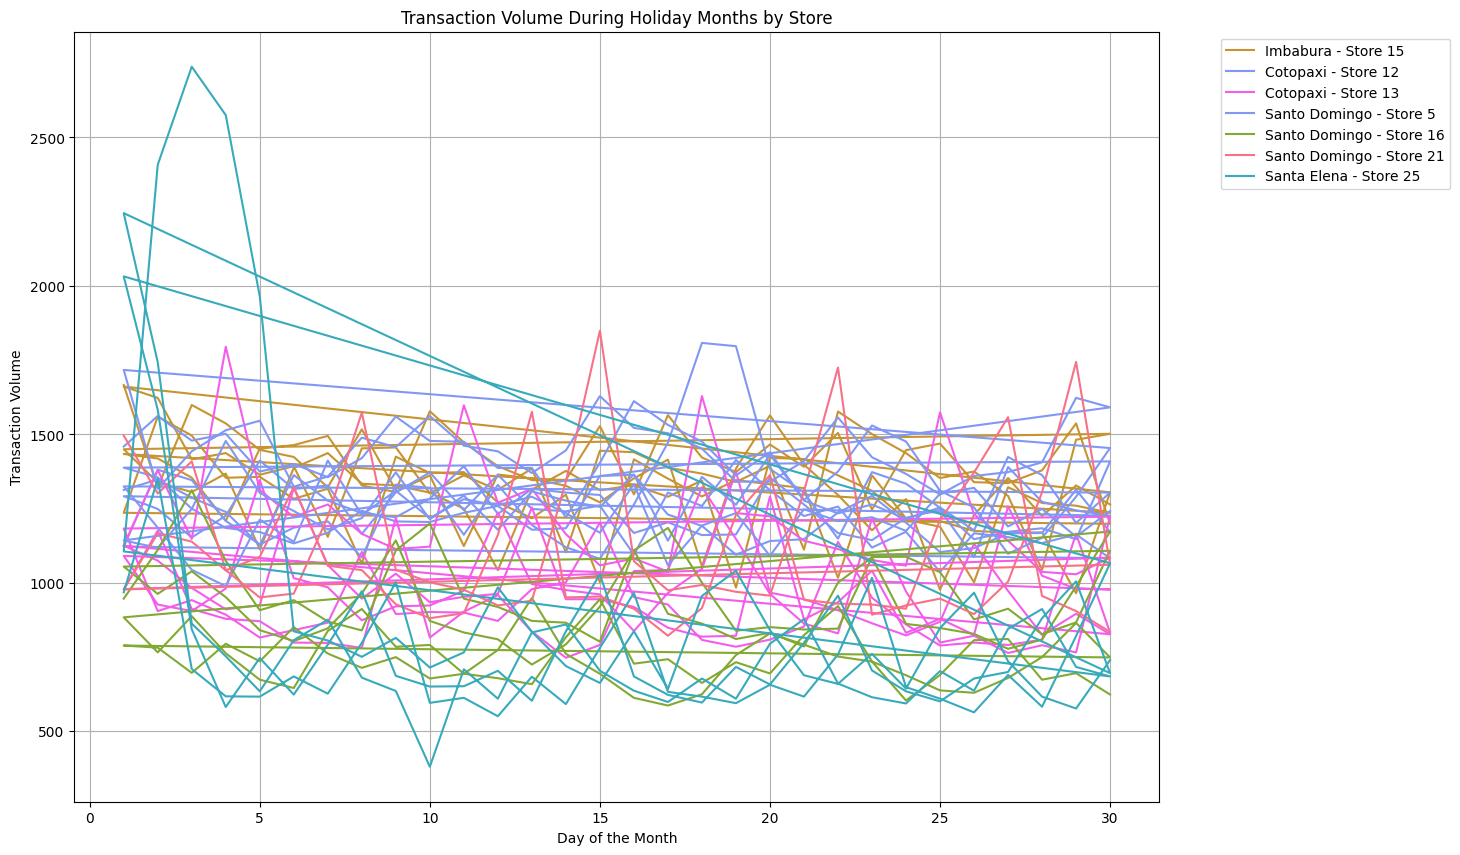

In [32]:
# Plotting the transaction volumes
plt.figure(figsize=(14, 10))

num_pallets = len(filtered_transactions_Cotopaxi.store_nbr.unique())+len(filtered_transactions_Imbabura.store_nbr.unique())+len(filtered_transactions_Santo_Domingo_de_los_Tsachilas.store_nbr.unique())+len(filtered_transactions_Santa_Elena.store_nbr.unique())
# Set a color palette
palette = sns.color_palette("husl", num_pallets)

# Plot transactions for Imbabura
for store, data in filtered_transactions_Imbabura.groupby('store_nbr'):
    plt.plot(data['day'], data['transactions'], label=f'Imbabura - Store {store}', color=palette[store % len(palette)])

# Plot transactions for Cotopaxi
for store, data in filtered_transactions_Cotopaxi.groupby('store_nbr'):
    plt.plot(data['day'], data['transactions'], label=f'Cotopaxi - Store {store}', color=palette[store % len(palette)])

# Plot transactions for Santo Domingo de los Tsachilas
for store, data in filtered_transactions_Santo_Domingo_de_los_Tsachilas.groupby('store_nbr'):
    plt.plot(data['day'], data['transactions'], label=f'Santo Domingo - Store {store}', color=palette[store % len(palette)])

# Plot transactions for Santa Elena
for store, data in filtered_transactions_Santa_Elena.groupby('store_nbr'):
    plt.plot(data['day'], data['transactions'], label=f'Santa Elena - Store {store}', color=palette[store % len(palette)])

plt.xlabel('Day of the Month')
plt.ylabel('Transaction Volume')
plt.title('Transaction Volume During Holiday Months by Store')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

going through these it's not easy to tell if it has any impact, it looks like there is a big impact on some stores and no impact at all on others. I'll look into it later with an f statistic when other variables are taken into account (day of week especially)